In [2]:
pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.3/152.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 5.9 MB/s eta 0:00:00


In [5]:
# prompt: CONNECT TO GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.single_table import GaussianCopulaSynthesizer
from sklearn.preprocessing import StandardScaler

def apply_dp_basic(df, epsilon=1.0):
    """
    Apply basic differential privacy using Laplace noise with proper scaling
    """
    dp_df = df.copy()
    scaler = StandardScaler()

    for column in df.columns:
        # Scale the data
        data = df[[column]].values
        scaled_data = scaler.fit_transform(data).flatten()

        # Calculate sensitivity based on scaled data
        sensitivity = 2.0  # Range of standardized data is roughly ±3

        # Add Laplace noise
        scale = sensitivity / epsilon
        noise = np.random.laplace(0, scale, size=len(scaled_data))

        # Add noise and inverse transform
        noisy_scaled = scaled_data + noise
        dp_df[column] = scaler.inverse_transform(noisy_scaled.reshape(-1, 1)).flatten()

        # Clip to reasonable bounds (±3 standard deviations)
        mean, std = df[column].mean(), df[column].std()
        dp_df[column] = np.clip(dp_df[column], mean - 3*std, mean + 3*std)

    return dp_df

def apply_dp_tensorflow_v2(df, epsilon=1.0):
    """
    Apply differential privacy using Gaussian mechanism with proper scaling
    """
    dp_df = df.copy()
    scaler = StandardScaler()

    for column in df.columns:
        # Scale the data
        data = df[[column]].values
        scaled_data = scaler.fit_transform(data).flatten()

        # Calculate sensitivity and noise scale
        sensitivity = 2.0
        noise_scale = sensitivity / epsilon

        # Add Gaussian noise
        noise = np.random.normal(0, noise_scale, size=len(scaled_data))
        noisy_scaled = scaled_data + noise

        # Inverse transform and clip
        dp_df[column] = scaler.inverse_transform(noisy_scaled.reshape(-1, 1)).flatten()
        mean, std = df[column].mean(), df[column].std()
        dp_df[column] = np.clip(dp_df[column], mean - 3*std, mean + 3*std)

    return dp_df

def calculate_privacy_metrics(original_df, private_df):
    """
    Calculate privacy and utility metrics with normalized values
    """
    # Initialize scaler
    scaler = StandardScaler()

    # Calculate metrics using normalized data
    normalized_metrics = {}

    for column in original_df.columns:
        # Scale original and private data
        orig_scaled = scaler.fit_transform(original_df[[column]])
        priv_scaled = scaler.transform(private_df[[column]])

        normalized_metrics[column] = {
            'mae': np.mean(np.abs(orig_scaled - priv_scaled)),
            'rmse': np.sqrt(np.mean((orig_scaled - priv_scaled)**2)),
            'correlation': np.corrcoef(orig_scaled.flatten(), priv_scaled.flatten())[0,1]
        }

    # Aggregate metrics
    metrics = {
        'mean_absolute_error': np.mean([m['mae'] for m in normalized_metrics.values()]),
        'correlation_preservation': {
            'original': original_df.corr().values.mean(),
            'private': private_df.corr().values.mean()
        },
        'per_column_metrics': normalized_metrics
    }

    return metrics

def compare_methods(df, epsilon=1.0):
    """
    Compare different DP methods
    """
    results = {}

    # Basic DP
    try:
        basic_dp_df = apply_dp_basic(df, epsilon=epsilon)
        results['Basic_DP'] = calculate_privacy_metrics(df, basic_dp_df)
    except Exception as e:
        results['Basic_DP'] = f"Error: {str(e)}"

    # TensorFlow approach
    try:
        tf_dp_df = apply_dp_tensorflow_v2(df, epsilon=epsilon)
        results['TensorFlow'] = calculate_privacy_metrics(df, tf_dp_df)
    except Exception as e:
        results['TensorFlow'] = f"Error: {str(e)}"

    return results

def plot_privacy_utility_tradeoff_simple(results):
    """
    Plot privacy-utility tradeoff with better scaling
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    methods = ['Basic_DP', 'TensorFlow']
    colors = ['blue', 'red']

    for method, color in zip(methods, colors):
        epsilons = []
        maes = []
        corr_diffs = []

        for eps in results.keys():
            metrics = results[eps].get(method)
            if isinstance(metrics, dict):
                epsilons.append(eps)
                maes.append(metrics['mean_absolute_error'])
                corr_diff = abs(
                    metrics['correlation_preservation']['original'] -
                    metrics['correlation_preservation']['private']
                )
                corr_diffs.append(corr_diff)

        if epsilons:
            ax1.plot(epsilons, maes, 'o-', label=method, color=color)
            ax2.plot(epsilons, corr_diffs, 'o-', label=method, color=color)

    ax1.set_xscale('log')
    ax1.set_title('Privacy-Utility Tradeoff (MAE)')
    ax1.set_xlabel('Epsilon (log scale)')
    ax1.set_ylabel('Mean Absolute Error')
    ax1.legend()
    ax1.grid(True)

    ax2.set_xscale('log')
    ax2.set_title('Privacy-Utility Tradeoff (Correlation)')
    ax2.set_xlabel('Epsilon (log scale)')
    ax2.set_ylabel('Correlation Difference')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig

def plot_distributions(original_df, private_dfs, columns=None):
    """
    Plot distribution comparisons with better scaling
    """
    if columns is None:
        columns = original_df.columns[:3]

    n_cols = len(columns)
    fig, axes = plt.subplots(1, n_cols, figsize=(6*n_cols, 5))
    if n_cols == 1:
        axes = [axes]

    for ax, col in zip(axes, columns):
        # Plot original distribution
        sns.kdeplot(data=original_df[col], ax=ax, label='Original',
                   color='black', linewidth=2)

        # Plot private distributions
        for method, df in private_dfs.items():
            if isinstance(df, pd.DataFrame):
                sns.kdeplot(data=df[col], ax=ax, label=method,
                          alpha=0.7, linewidth=2)

        ax.set_title(f'Distribution of {col}')
        ax.legend()

        # Add mean lines
        ax.axvline(original_df[col].mean(), color='black', linestyle='--', alpha=0.5)
        for method, df in private_dfs.items():
            if isinstance(df, pd.DataFrame):
                ax.axvline(df[col].mean(), color=ax.lines[-1].get_color(),
                          linestyle='--', alpha=0.5)

    plt.tight_layout()
    return fig

def run_analysis():
    """
    Run the complete privacy analysis
    """
    # Load data
    print("Loading data...")
    data_path = "/content/drive/MyDrive/Colab Notebooks/Marquette/COSC6960 Fall 24 - PPML/faketucky.dta"
    df = pd.read_stata(data_path)

    # Select numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Print initial statistics about NaN values
    print("\nNaN percentages for numerical columns:")
    for col in numeric_cols:
        nan_pct = df[col].isna().mean() * 100
        print(f"{col}: {nan_pct:.2f}%")

    # Select columns with less than 50% NaN values
    valid_cols = [col for col in numeric_cols
                 if df[col].isna().mean() < 0.5 and df[col].std() > 0]

    print(f"\nSelected {len(valid_cols)} columns with < 50% NaN values:")
    for col in valid_cols:
        print(f"- {col}")

    # Create analysis dataset
    df_numeric = df[valid_cols].copy()

    # Fill NaN values with column means
    for col in df_numeric.columns:
        df_numeric[col] = df_numeric[col].fillna(df_numeric[col].mean())

    print("\nAnalyzing selected columns:")
    for col in valid_cols:
        print(f"\n{col}:")
        print(f"  Mean: {df_numeric[col].mean():.4f}")
        print(f"  Std: {df_numeric[col].std():.4f}")
        print(f"  Range: [{df_numeric[col].min():.4f}, {df_numeric[col].max():.4f}]")

    # Run comparisons with different epsilon values
    epsilons = [0.1, 1.0, 10.0]
    results = {}

    for eps in epsilons:
        print(f"\nProcessing epsilon = {eps}")
        results[eps] = compare_methods(df_numeric, epsilon=eps)

        # Print current results
        print(f"\nResults for epsilon = {eps}:")
        for method, metrics in results[eps].items():
            if isinstance(metrics, dict):
                print(f"\n{method}:")
                print(f"  MAE: {metrics['mean_absolute_error']:.4f}")
                print(f"  Original correlation: {metrics['correlation_preservation']['original']:.4f}")
                print(f"  Private correlation: {metrics['correlation_preservation']['private']:.4f}")

    # Generate visualizations
    print("\nGenerating privacy-utility tradeoff plot...")
    fig_tradeoff = plot_privacy_utility_tradeoff_simple(results)
    plt.show()

    # Generate private datasets for epsilon=1.0
    print("\nGenerating private datasets for distribution comparison...")
    private_dfs = {}

    try:
        private_dfs['Basic_DP'] = apply_dp_basic(df_numeric, epsilon=1.0)
        print("Basic DP successful")
    except Exception as e:
        print(f"Error with Basic DP: {str(e)}")

    try:
        private_dfs['TensorFlow'] = apply_dp_tensorflow_v2(df_numeric, epsilon=1.0)
        print("TensorFlow successful")
    except Exception as e:
        print(f"Error with TensorFlow: {str(e)}")

    # Plot distributions
    if private_dfs:
        print("\nGenerating distribution comparison plots...")
        # Select columns with highest non-zero standard deviation
        std_devs = df_numeric.std()
        columns_to_plot = std_devs.nlargest(3).index.tolist()

        fig_dist = plot_distributions(df_numeric, private_dfs, columns=columns_to_plot)
        plt.show()

        # Print verification statistics
        print("\nVerification Statistics:")
        for col in columns_to_plot:
            print(f"\nColumn: {col}")
            print(f"Original mean: {df_numeric[col].mean():.4f}")
            print(f"Original std: {df_numeric[col].std():.4f}")
            for method, private_df in private_dfs.items():
                print(f"{method}:")
                print(f"  Mean: {private_df[col].mean():.4f}")
                print(f"  Std: {private_df[col].std():.4f}")

    return results, private_dfs, df_numeric

# Run with this code:
if __name__ == "__main__":
    %matplotlib inline
    #plt.style.use('seaborn')


Loading data...

NaN percentages for numerical columns:
sid: 0.00%
first_dist_code: 0.00%
first_hs_code: 0.00%
first_hs_alt: 0.00%
chrt_ninth: 0.00%
male: 0.02%
frpl_ever_in_hs: 1.26%
sped_ever_in_hs: 0.00%
lep_ever_in_hs: 0.00%
gifted_ever_in_hs: 0.00%
ever_alt_sch_in_hs: 0.00%
scale_score_6_math: 62.01%
scale_score_6_read: 62.01%
scale_score_8_math: 17.40%
scale_score_8_read: 17.64%
pct_absent_in_hs: 0.20%
pct_excused_in_hs: 0.20%
avg_gpa_hs: 3.34%
scale_score_11_eng: 23.09%
scale_score_11_math: 23.10%
scale_score_11_read: 23.12%
scale_score_11_comp: 23.13%
collegeready_ever_in_hs: 0.00%
careerready_ever_in_hs: 0.00%
ap_ever_take_class: 0.00%
last_acadyr_observed: 0.00%
transferout: 0.00%
dropout: 0.00%
still_enrolled: 0.00%
ontime_grad: 0.00%
chrt_grad: 23.96%
hs_diploma: 0.00%
enroll_yr1_any: 23.96%
enroll_yr1_2yr: 23.96%
enroll_yr1_4yr: 23.96%
enroll_yr2_any: 23.96%
ihe_code_yr1: 60.32%
ihe_act_25th_pctl_cumulative: 76.69%
ihe_act_75th_pctl_cumulative: 76.69%
ihe_act_midpoint_cumu

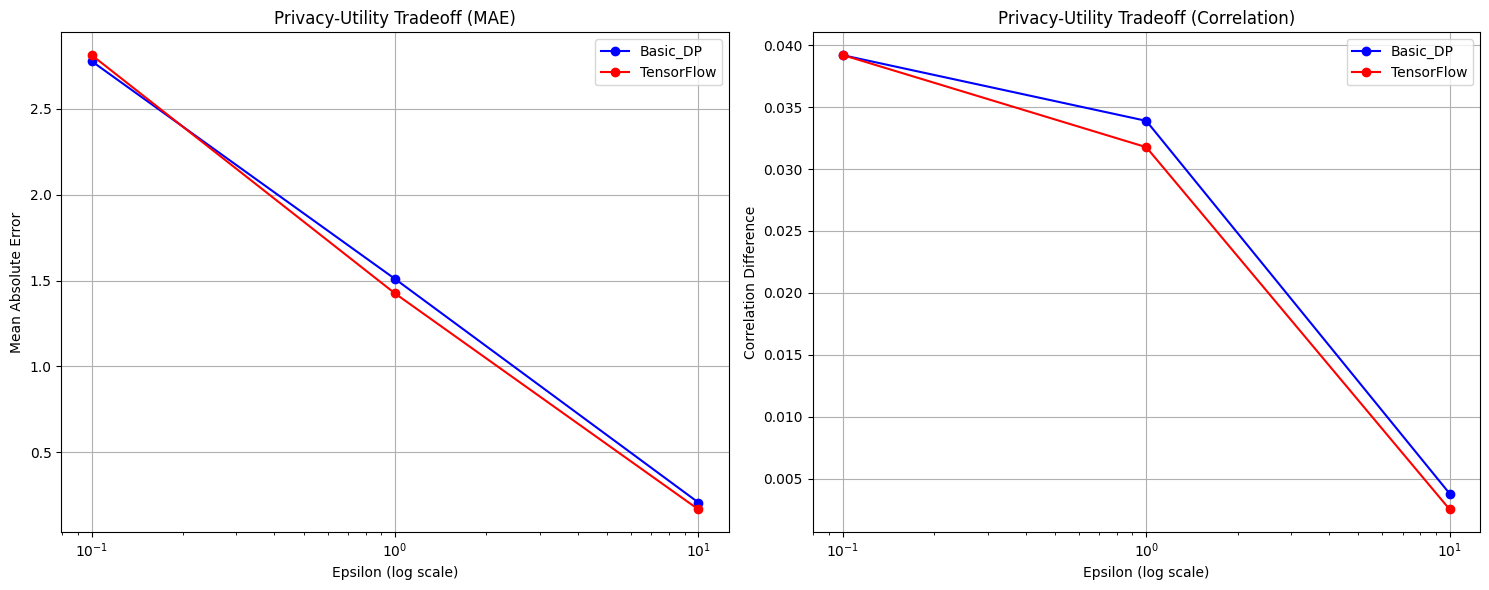


Generating private datasets for distribution comparison...
Basic DP successful
TensorFlow successful

Generating distribution comparison plots...


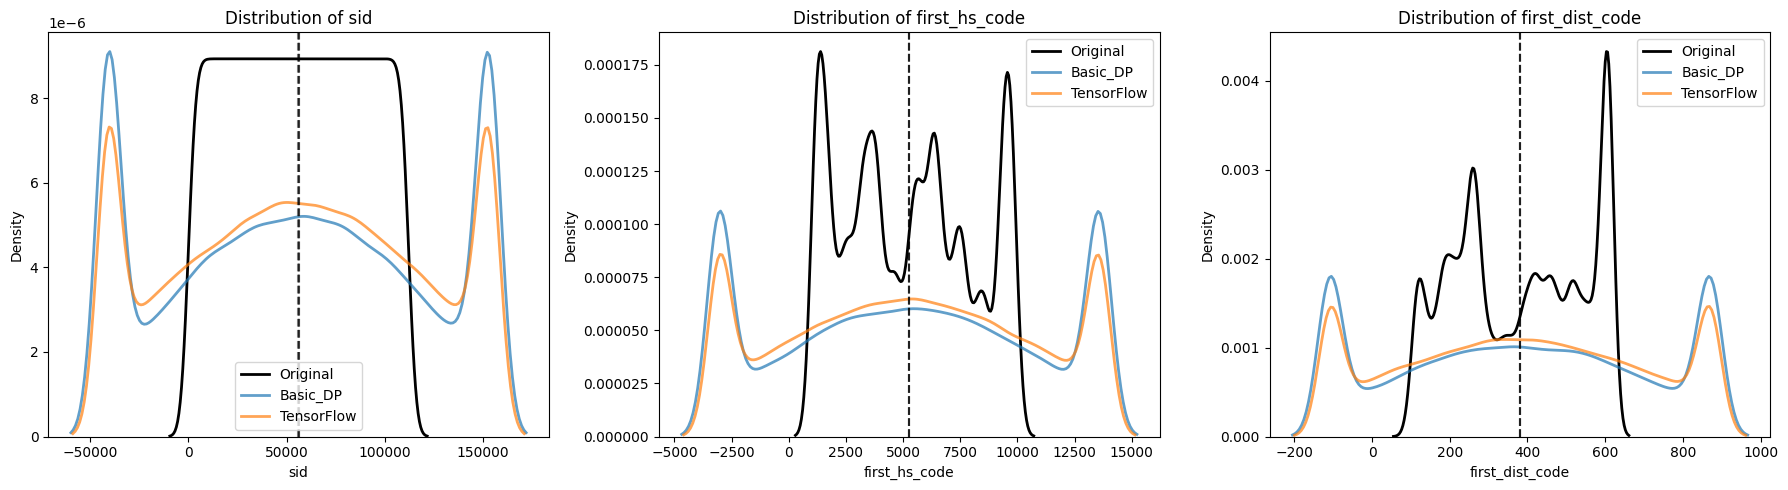


Verification Statistics:

Column: sid
Original mean: 55996.0000
Original std: 32329.1613
Basic_DP:
  Mean: 55898.4146
  Std: 64253.7863
TensorFlow:
  Mean: 56091.9915
  Std: 60856.6146

Column: first_hs_code
Original mean: 5273.1355
Original std: 2777.9296
Basic_DP:
  Mean: 5267.0657
  Std: 5532.8108
TensorFlow:
  Mean: 5251.8195
  Std: 5235.2549

Column: first_dist_code
Original mean: 380.9259
Original std: 163.3817
Basic_DP:
  Mean: 380.6230
  Std: 325.6642
TensorFlow:
  Mean: 380.6307
  Std: 308.4217


In [9]:
%matplotlib inline
# The code will use matplotlib's default style
results, private_dfs, original_data = run_analysis()

Loading data...

NaN percentages for numerical columns:
sid: 0.00%
first_dist_code: 0.00%
first_hs_code: 0.00%
first_hs_alt: 0.00%
chrt_ninth: 0.00%
male: 0.02%
frpl_ever_in_hs: 1.26%
sped_ever_in_hs: 0.00%
lep_ever_in_hs: 0.00%
gifted_ever_in_hs: 0.00%
ever_alt_sch_in_hs: 0.00%
scale_score_6_math: 62.01%
scale_score_6_read: 62.01%
scale_score_8_math: 17.40%
scale_score_8_read: 17.64%
pct_absent_in_hs: 0.20%
pct_excused_in_hs: 0.20%
avg_gpa_hs: 3.34%
scale_score_11_eng: 23.09%
scale_score_11_math: 23.10%
scale_score_11_read: 23.12%
scale_score_11_comp: 23.13%
collegeready_ever_in_hs: 0.00%
careerready_ever_in_hs: 0.00%
ap_ever_take_class: 0.00%
last_acadyr_observed: 0.00%
transferout: 0.00%
dropout: 0.00%
still_enrolled: 0.00%
ontime_grad: 0.00%
chrt_grad: 23.96%
hs_diploma: 0.00%
enroll_yr1_any: 23.96%
enroll_yr1_2yr: 23.96%
enroll_yr1_4yr: 23.96%
enroll_yr2_any: 23.96%
ihe_code_yr1: 60.32%
ihe_act_25th_pctl_cumulative: 76.69%
ihe_act_75th_pctl_cumulative: 76.69%
ihe_act_midpoint_cumu

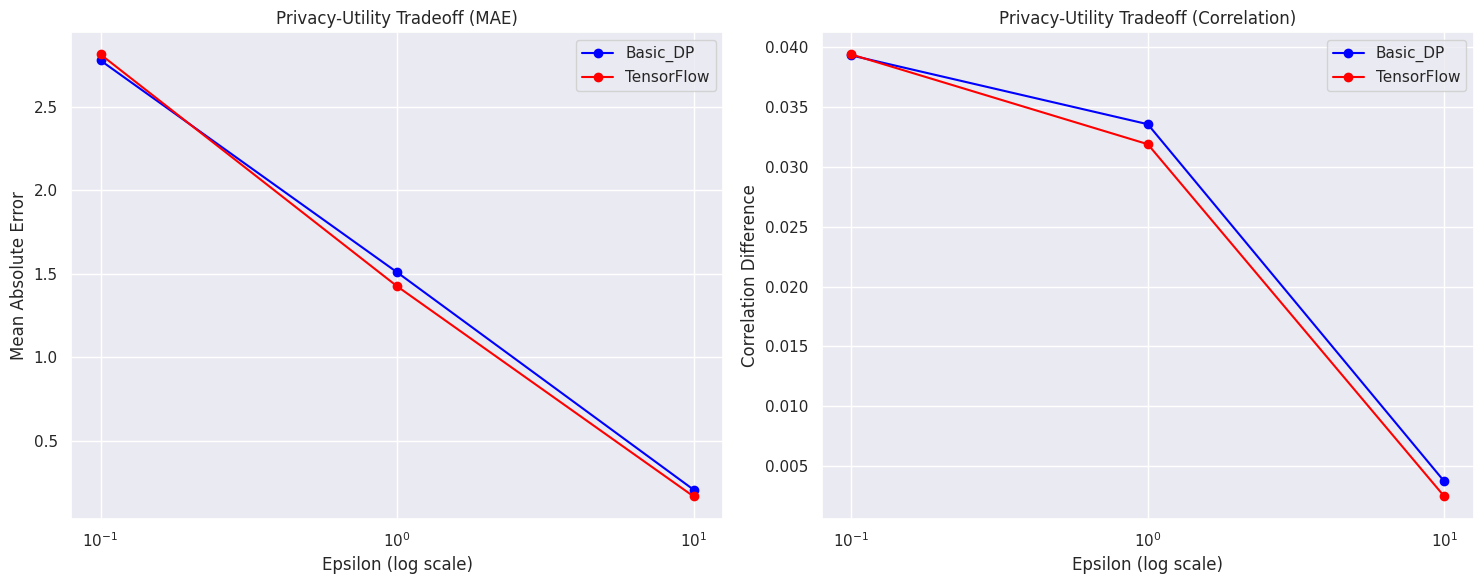


Generating private datasets for distribution comparison...
Basic DP successful
TensorFlow successful

Generating distribution comparison plots...


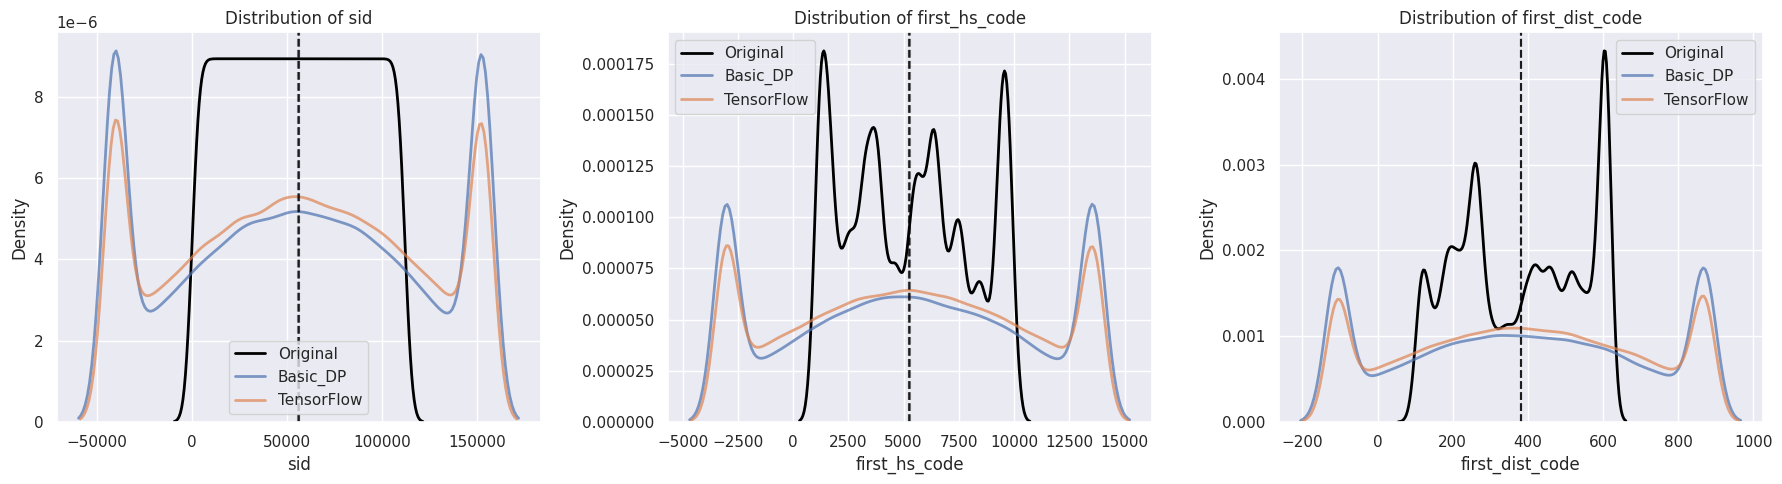


Verification Statistics:

Column: sid
Original mean: 55996.0000
Original std: 32329.1613
Basic_DP:
  Mean: 55896.6979
  Std: 64307.7339
TensorFlow:
  Mean: 56075.2731
  Std: 61044.0079

Column: first_hs_code
Original mean: 5273.1355
Original std: 2777.9296
Basic_DP:
  Mean: 5262.6972
  Std: 5526.5598
TensorFlow:
  Mean: 5258.5302
  Std: 5248.3570

Column: first_dist_code
Original mean: 380.9259
Original std: 163.3817
Basic_DP:
  Mean: 380.8190
  Std: 325.5519
TensorFlow:
  Mean: 383.0358
  Std: 307.5980

Generating enrollment distribution comparison...

Statistics for enroll_yr2_any:

Original Data:
Mean: 0.2205
Std: 0.3615
Min: 0.0000
Max: 1.0000

Basic_DP:
Mean: 0.2173
Std: 0.7179
Min: -0.8641
Max: 1.3050
Mean Absolute Error: 0.5408

TensorFlow:
Mean: 0.2099
Std: 0.6780
Min: -0.8641
Max: 1.3050
Mean Absolute Error: 0.5088


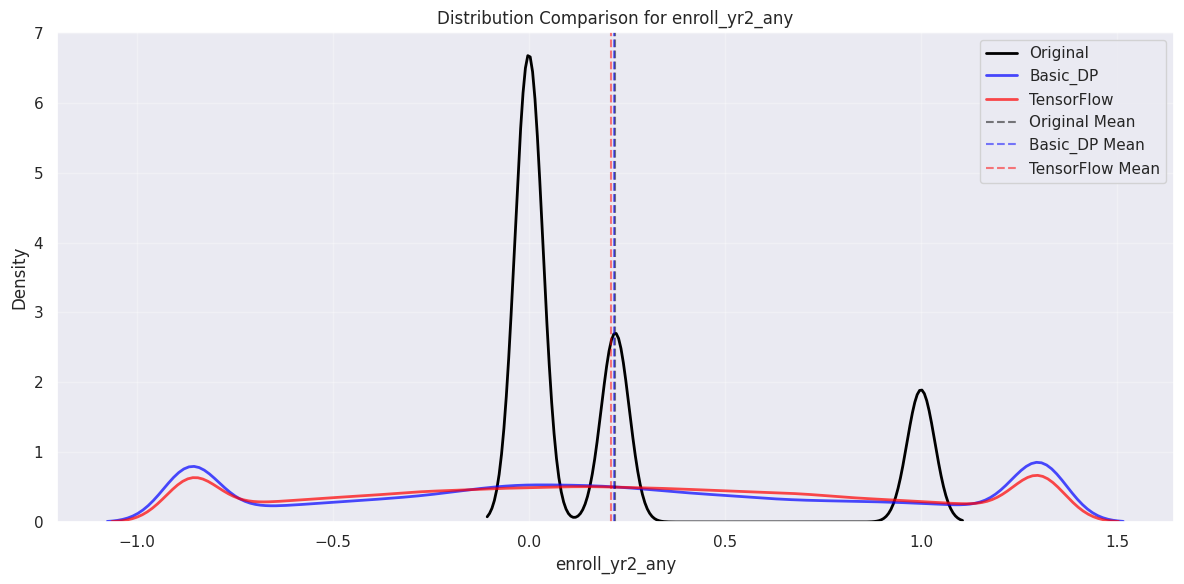

In [10]:
def plot_single_distribution_comparison(original_df, private_dfs, column='enroll_yr2_any'):
    """
    Create a detailed distribution comparison plot for a single column
    """
    plt.figure(figsize=(12, 6))

    # Plot original distribution
    sns.kdeplot(data=original_df[column], label='Original',
                color='black', linewidth=2)

    # Plot private distributions
    colors = ['blue', 'red']
    for (method, df), color in zip(private_dfs.items(), colors):
        if isinstance(df, pd.DataFrame):
            sns.kdeplot(data=df[column], label=method,
                       color=color, alpha=0.7, linewidth=2)

    # Add mean lines
    plt.axvline(original_df[column].mean(), color='black',
                linestyle='--', alpha=0.5, label='Original Mean')

    for (method, df), color in zip(private_dfs.items(), colors):
        if isinstance(df, pd.DataFrame):
            plt.axvline(df[column].mean(), color=color,
                       linestyle='--', alpha=0.5,
                       label=f'{method} Mean')

    plt.title(f'Distribution Comparison for {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Print statistics
    print(f"\nStatistics for {column}:")
    print("\nOriginal Data:")
    print(f"Mean: {original_df[column].mean():.4f}")
    print(f"Std: {original_df[column].std():.4f}")
    print(f"Min: {original_df[column].min():.4f}")
    print(f"Max: {original_df[column].max():.4f}")

    for method, df in private_dfs.items():
        if isinstance(df, pd.DataFrame):
            print(f"\n{method}:")
            print(f"Mean: {df[column].mean():.4f}")
            print(f"Std: {df[column].std():.4f}")
            print(f"Min: {df[column].min():.4f}")
            print(f"Max: {df[column].max():.4f}")
            print(f"Mean Absolute Error: {np.mean(np.abs(original_df[column] - df[column])):.4f}")

    plt.tight_layout()
    plt.show()

# Run the analysis and create the enrollment plot
if __name__ == "__main__":
    # Setup plotting
    %matplotlib inline
    plt.style.use('default')
    sns.set_theme()

    # Run main analysis
    results, private_dfs, original_data = run_analysis()

    # Create specific plot for enrollment
    print("\nGenerating enrollment distribution comparison...")
    plot_single_distribution_comparison(original_data, private_dfs, 'enroll_yr2_any')

Loading data...

Generating binary distribution comparison...


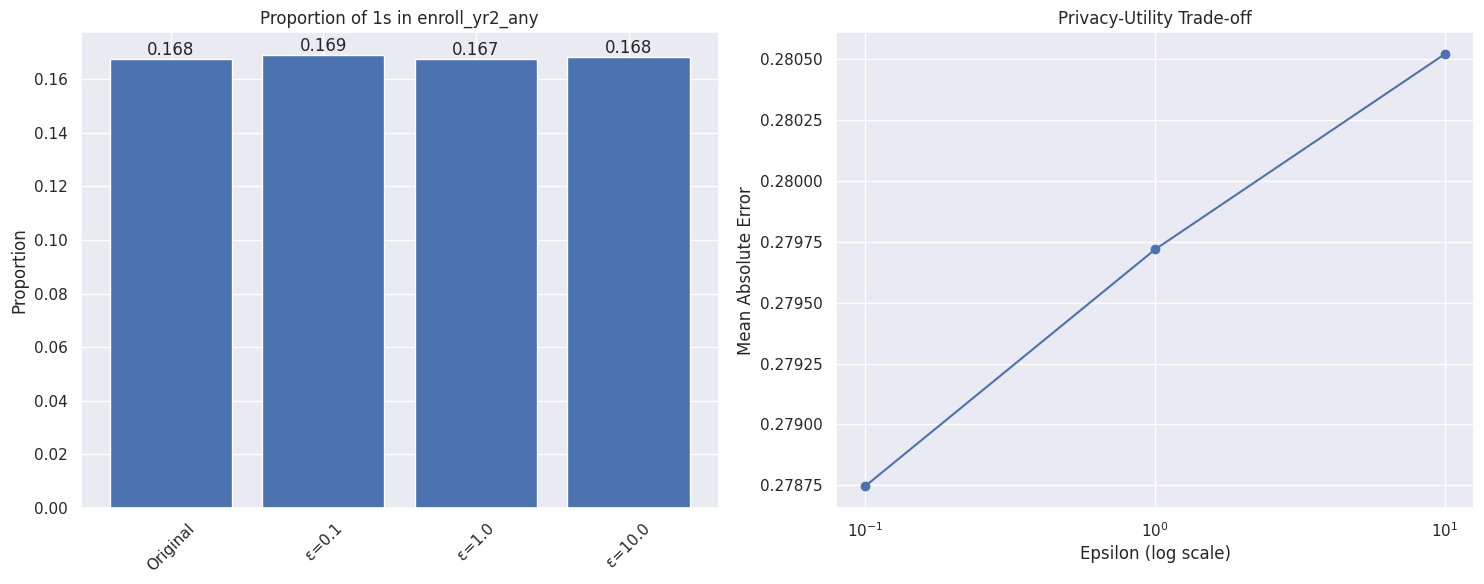


Detailed Statistics for enroll_yr2_any:

Original Data:
Mean (proportion of 1s): 0.1677
Count of 1s: 18776.0
Total count: 111991

Privatized Data:

Epsilon = 0.1:
Mean (proportion of 1s): 0.1690
Count of 1s: 18929
Mean Absolute Error: 0.2787
Preservation Rate: 0.7213

Epsilon = 1.0:
Mean (proportion of 1s): 0.1675
Count of 1s: 18756
Mean Absolute Error: 0.2797
Preservation Rate: 0.7203

Epsilon = 10.0:
Mean (proportion of 1s): 0.1681
Count of 1s: 18828
Mean Absolute Error: 0.2805
Preservation Rate: 0.7195


In [11]:
# Change to optimize for binary value in enroll_yr2_any
def apply_dp_binary(df, column, epsilon=1.0):
    """
    Apply differential privacy specifically for binary data
    """
    dp_df = df.copy()

    # Get original probability
    p_original = df[column].mean()

    # Add Laplace noise to the count and total
    count = len(df)
    sensitivity = 1.0  # For binary data
    noisy_ones = df[column].sum() + np.random.laplace(0, sensitivity/epsilon)

    # Calculate noisy probability
    p_noisy = np.clip(noisy_ones / count, 0, 1)

    # Generate new binary data preserving noisy probability
    dp_df[column] = np.random.binomial(n=1, p=p_noisy, size=len(df))

    return dp_df

def plot_binary_distribution_comparison(original_df, column='enroll_yr2_any', epsilons=[0.1, 1.0, 10.0]):
    """
    Create comparison plots for binary data with different privacy levels
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Store results for different epsilon values
    results = {}
    for eps in epsilons:
        dp_df = apply_dp_binary(original_df, column, epsilon=eps)
        results[eps] = dp_df[column]

    # Plot 1: Bar plot of proportions
    proportions = {
        'Original': original_df[column].mean(),
        **{f'ε={eps}': results[eps].mean() for eps in epsilons}
    }

    bars = ax1.bar(range(len(proportions)), proportions.values())
    ax1.set_xticks(range(len(proportions)))
    ax1.set_xticklabels(proportions.keys(), rotation=45)
    ax1.set_title(f'Proportion of 1s in {column}')
    ax1.set_ylabel('Proportion')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    # Plot 2: Privacy-utility trade-off
    errors = [np.mean(np.abs(original_df[column] - results[eps])) for eps in epsilons]
    ax2.plot(epsilons, errors, 'o-', label='Mean Absolute Error')
    ax2.set_xscale('log')
    ax2.set_xlabel('Epsilon (log scale)')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.set_title('Privacy-Utility Trade-off')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print(f"\nDetailed Statistics for {column}:")
    print(f"\nOriginal Data:")
    print(f"Mean (proportion of 1s): {original_df[column].mean():.4f}")
    print(f"Count of 1s: {original_df[column].sum()}")
    print(f"Total count: {len(original_df)}")

    print("\nPrivatized Data:")
    for eps in epsilons:
        print(f"\nEpsilon = {eps}:")
        print(f"Mean (proportion of 1s): {results[eps].mean():.4f}")
        print(f"Count of 1s: {results[eps].sum()}")
        print(f"Mean Absolute Error: {np.mean(np.abs(original_df[column] - results[eps])):.4f}")
        print(f"Preservation Rate: {1 - np.mean(np.abs(original_df[column] - results[eps])):.4f}")

# Run the analysis with binary-specific approach
if __name__ == "__main__":
    # Setup plotting
    %matplotlib inline
    plt.style.use('default')
    sns.set_theme()

    # Load data
    print("Loading data...")
    data_path = "/content/drive/MyDrive/Colab Notebooks/Marquette/COSC6960 Fall 24 - PPML/faketucky.dta"
    df = pd.read_stata(data_path)

    # Clean the enrollment data
    df_clean = df.copy()
    df_clean['enroll_yr2_any'] = df_clean['enroll_yr2_any'].fillna(0)

    # Create binary-specific privacy analysis
    print("\nGenerating binary distribution comparison...")
    plot_binary_distribution_comparison(df_clean, 'enroll_yr2_any',
                                     epsilons=[0.1, 1.0, 10.0])

Loading data...
Loading data...

NaN percentages for numerical columns:
sid: 0.00%
first_dist_code: 0.00%
first_hs_code: 0.00%
first_hs_alt: 0.00%
chrt_ninth: 0.00%
male: 0.02%
frpl_ever_in_hs: 1.26%
sped_ever_in_hs: 0.00%
lep_ever_in_hs: 0.00%
gifted_ever_in_hs: 0.00%
ever_alt_sch_in_hs: 0.00%
scale_score_6_math: 62.01%
scale_score_6_read: 62.01%
scale_score_8_math: 17.40%
scale_score_8_read: 17.64%
pct_absent_in_hs: 0.20%
pct_excused_in_hs: 0.20%
avg_gpa_hs: 3.34%
scale_score_11_eng: 23.09%
scale_score_11_math: 23.10%
scale_score_11_read: 23.12%
scale_score_11_comp: 23.13%
collegeready_ever_in_hs: 0.00%
careerready_ever_in_hs: 0.00%
ap_ever_take_class: 0.00%
last_acadyr_observed: 0.00%
transferout: 0.00%
dropout: 0.00%
still_enrolled: 0.00%
ontime_grad: 0.00%
chrt_grad: 23.96%
hs_diploma: 0.00%
enroll_yr1_any: 23.96%
enroll_yr1_2yr: 23.96%
enroll_yr1_4yr: 23.96%
enroll_yr2_any: 23.96%
ihe_code_yr1: 60.32%
ihe_act_25th_pctl_cumulative: 76.69%
ihe_act_75th_pctl_cumulative: 76.69%
ihe_a

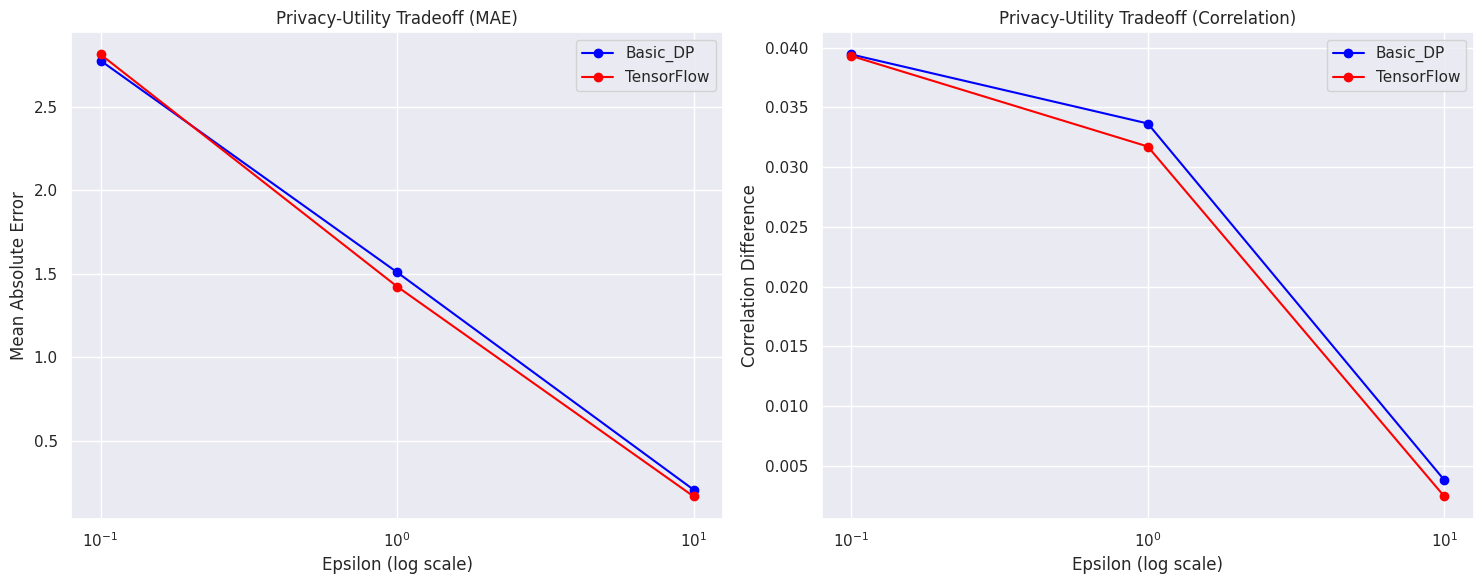


Generating private datasets for distribution comparison...
Basic DP successful
TensorFlow successful

Generating distribution comparison plots...


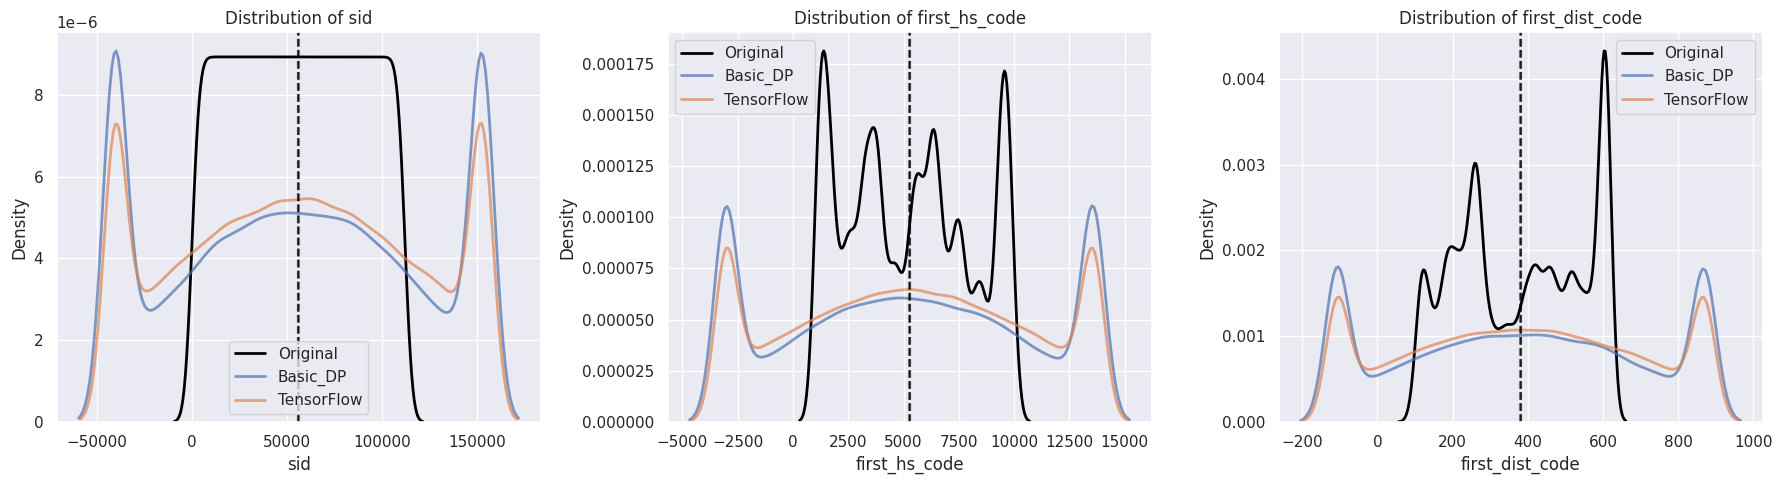


Verification Statistics:

Column: sid
Original mean: 55996.0000
Original std: 32329.1613
Basic_DP:
  Mean: 55791.4813
  Std: 64246.7921
TensorFlow:
  Mean: 55827.2519
  Std: 61039.7603

Column: first_hs_code
Original mean: 5273.1355
Original std: 2777.9296
Basic_DP:
  Mean: 5251.5108
  Std: 5517.6134
TensorFlow:
  Mean: 5273.1975
  Std: 5228.6357

Column: first_dist_code
Original mean: 380.9259
Original std: 163.3817
Basic_DP:
  Mean: 380.1069
  Std: 324.8939
TensorFlow:
  Mean: 380.6884
  Std: 308.3731

Comparing ML performance across datasets...
Preparing original data...

Feature columns: ['male', 'frpl_ever_in_hs', 'scale_score_8_math', 'scale_score_8_read', 'pct_absent_in_hs', 'pct_excused_in_hs', 'avg_gpa_hs', 'scale_score_11_eng', 'scale_score_11_math', 'scale_score_11_read', 'scale_score_11_comp', 'chrt_grad', 'enroll_yr1_any', 'enroll_yr1_2yr', 'enroll_yr1_4yr']

Target distribution:
enroll_yr2_any
0    0.592762
1    0.407238
Name: proportion, dtype: float64

Evaluating origi

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:14:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Results for Original Data:
-------------------------
Accuracy: 0.9330
F1 Score: 0.9188

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     13277
           1       0.91      0.93      0.92      9122

    accuracy                           0.93     22399
   macro avg       0.93      0.93      0.93     22399
weighted avg       0.93      0.93      0.93     22399


Evaluating Basic_DP...

Training on Basic_DP
Training set size: 89592
Test set size: 22399
Class distribution in training: 
enroll_yr2_any
1    0.593669
0    0.406331
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:14:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Results for Basic_DP:
-------------------------
Accuracy: 0.5936
F1 Score: 0.7431

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.01      0.03      9073
           1       0.60      0.99      0.74     13326

    accuracy                           0.59     22399
   macro avg       0.52      0.50      0.39     22399
weighted avg       0.54      0.59      0.45     22399


Evaluating TensorFlow...

Training on TensorFlow
Training set size: 89592
Test set size: 22399
Class distribution in training: 
enroll_yr2_any
1    0.59666
0    0.40334
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:14:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Results for TensorFlow:
-------------------------
Accuracy: 0.5983
F1 Score: 0.7456

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.02      0.05      8977
           1       0.60      0.98      0.75     13422

    accuracy                           0.60     22399
   macro avg       0.54      0.50      0.40     22399
weighted avg       0.55      0.60      0.47     22399


Plotting comparison results...


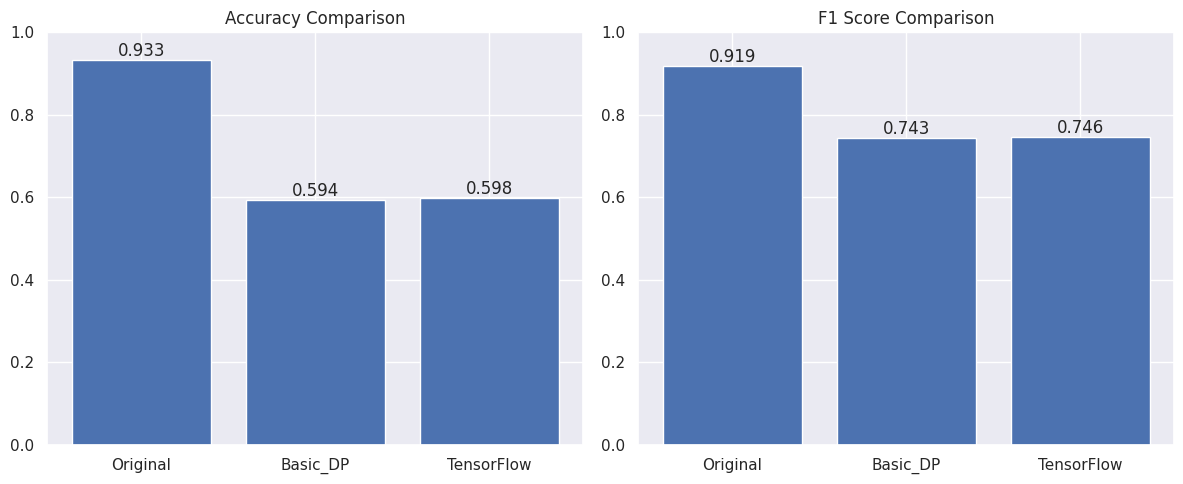

In [13]:
def prepare_data(df, target='enroll_yr2_any'):
    """
    Prepare data for modeling by handling missing values and encoding
    """
    # Copy the dataframe
    df = df.copy()

    # Get feature columns (excluding target and any ID columns)
    feature_cols = [col for col in df.columns
                   if col != target
                   and not col.lower().endswith('id')
                   and df[col].dtype in ['int64', 'float64']]

    # Fill missing values with mean for numeric columns
    for col in feature_cols:
        df[col] = df[col].fillna(df[col].mean())

    # Binarize the target variable (convert to 0 or 1)
    df[target] = df[target].fillna(0)
    df[target] = (df[target] > 0).astype(int)

    return df, feature_cols

def compare_datasets(original_df, private_dfs, target='enroll_yr2_any'):
    """
    Compare model performance across original and private datasets
    """
    # Prepare datasets
    results = {}
    predictions = {}

    # Process original data
    print("Preparing original data...")
    df_original, feature_cols = prepare_data(original_df, target)

    print("\nFeature columns:", feature_cols)
    print(f"\nTarget distribution:\n{df_original[target].value_counts(normalize=True)}")

    # Create train/test split
    X = df_original[feature_cols]
    y = df_original[target]

    # Use same train/test split for all datasets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate on original data
    print("\nEvaluating original data...")
    model_orig, acc_orig, f1_orig, pred_orig = train_and_evaluate(
        X_train_scaled, X_test_scaled, y_train, y_test, "Original Data"
    )
    results['Original'] = {'accuracy': acc_orig, 'f1': f1_orig}
    predictions['Original'] = pred_orig

    # Evaluate private datasets
    for method, private_df in private_dfs.items():
        print(f"\nEvaluating {method}...")

        # Prepare private data
        df_private, _ = prepare_data(private_df, target)
        X_private = df_private[feature_cols]
        y_private = df_private[target]

        # Use same train/test split indices
        X_train_private = X_private.iloc[X_train.index]
        X_test_private = X_private.iloc[X_test.index]
        y_train_private = y_private.iloc[y_train.index]
        y_test_private = y_private.iloc[y_test.index]

        # Scale features
        X_train_private_scaled = scaler.fit_transform(X_train_private)
        X_test_private_scaled = scaler.transform(X_test_private)

        # Train and evaluate
        model, acc, f1, pred = train_and_evaluate(
            X_train_private_scaled, X_test_private_scaled,
            y_train_private, y_test_private, method
        )
        results[method] = {'accuracy': acc, 'f1': f1}
        predictions[method] = pred

    return results, predictions, y_test

def train_and_evaluate(X_train, X_test, y_train, y_test, dataset_name=""):
    """
    Train XGBoost and evaluate performance
    """
    print(f"\nTraining on {dataset_name}")
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Class distribution in training: \n{pd.Series(y_train).value_counts(normalize=True)}")

    # Initialize XGBoost classifier with adjusted parameters
    model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        objective='binary:logistic'  # Explicitly set binary classification
    )

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\nResults for {dataset_name}:")
    print("-------------------------")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return model, accuracy, f1, y_pred

# Run the analysis
if __name__ == "__main__":
    # Setup plotting
    %matplotlib inline
    plt.style.use('default')
    sns.set_theme()

    # Load and prepare data
    print("Loading data...")
    data_path = "/content/drive/MyDrive/Colab Notebooks/Marquette/COSC6960 Fall 24 - PPML/faketucky.dta"
    original_df = pd.read_stata(data_path)

    # Run privacy analysis to get private datasets
    results, private_dfs, original_data = run_analysis()

    print("\nComparing ML performance across datasets...")
    ml_results, predictions, y_test = compare_datasets(original_data, private_dfs)

    print("\nPlotting comparison results...")
    plot_results(ml_results)